## Traffic light control using Markov Decision Processes (MDP)

**Urban traffic congestion significantly affects travel time, CO₂ emissions, and citizen well-being. In this project, we model a realistic urban intersection in Casablanca using a Markov Decision Process (MDP) and optimize traffic light control using Value Iteration.** \\
We model the traffic optimization as an MDP:

The traffic light optimization problem is formulated as a Markov Decision Process (MDP) with the following components:

- **States**: 
  - Queue levels for North-South and East-West directions (discrete levels: 0–3)
  - Time of day (morning, afternoon, evening, night)
  - Day type (weekday or weekend)
  - Weather conditions (clear or rain)
  - Event activity (yes or no) and event type
  - Nearby landmark (hotel, stadium, airport, or none)

- **Actions**:
  - Green light for North-South or East-West (30s or 60s)
  - All-red phase (10s safety phase)

- **Reward Function**:
  - Negative reward proportional to total queue size and CO₂ proxy emissions
  - Event congestion penalties included

- **Transition Model**:
  - Stochastic vehicle arrivals based on real-time travel times 
  - Impact of weather and event on arrival rates


In [1]:
# TrafficState Class : MDP state
from dataclasses import dataclass

@dataclass(frozen=True)
class TrafficState:
    queue_ns: int        # Queue level for North-South (0 to 3)
    queue_ew: int        # Queue level for East-West (0 to 3)
    time_of_day: str     
    day_of_week: str     
    weather: str         
    event_active: bool   # Is an event happening?
    event_type: str      
    nearby_landmark: str 

    def to_tuple(self):
        return (self.queue_ns, self.queue_ew, self.time_of_day, self.day_of_week, 
                self.weather, self.event_active, self.event_type, self.nearby_landmark)

In [2]:
# TrafficAction Class: traffic light control
from enum import Enum

class TrafficAction(Enum):
    GREEN_NS_30 = 'green_ns_30'
    GREEN_EW_30 = 'green_ew_30'
    GREEN_NS_60 = 'green_ns_60'
    GREEN_EW_60 = 'green_ew_60'
    ALL_RED_10 = 'all_red_10'

    def duration(self):
        return {
            self.GREEN_NS_30: 30,
            self.GREEN_EW_30: 30,
            self.GREEN_NS_60: 60,
            self.GREEN_EW_60: 60,
            self.ALL_RED_10: 10
        }[self]

In [3]:
# MDPEnvironment Class: handles transitions, rewards, and state updates
import random
import numpy as np

class MDPEnvironment:
    def __init__(self, gamma=0.95, congestion_function=None):
        self.gamma = gamma
        self.congestion_function = congestion_function
        self.time_slots = ['morning', 'afternoon', 'evening', 'night']
        self.days = ['weekday', 'weekend']
        self.weather_conditions = ['clear', 'rain']
        self.event_types = ['none', 'holidays', 'conference', 'concert']
        self.landmarks = ['hotel', 'airport', 'stadium', 'none']

    def get_possible_states(self):
        return [
            TrafficState(q_ns, q_ew, t, d, w, e, et, l)
            for q_ns in range(4)
            for q_ew in range(4)
            for t in self.time_slots
            for d in self.days
            for w in self.weather_conditions
            for e in [True, False]
            for et in self.event_types
            for l in self.landmarks
        ]

    def transition(self, state: TrafficState, action: TrafficAction, step: int, current_hour: int) -> TrafficState:
        # update event_active based on simulation step
        event_active = self.is_event_active(step)

        λ = self._get_lambda(state, event_active, current_hour)  
        arrival_ns = np.random.poisson(λ)
        arrival_ew = np.random.poisson(λ)

        cleared_ns, cleared_ew = self._vehicles_cleared(state, action)

        new_ns = min(3, max(0, state.queue_ns + arrival_ns - cleared_ns))
        new_ew = min(3, max(0, state.queue_ew + arrival_ew - cleared_ew))

        return TrafficState(
            new_ns,
            new_ew,
            state.time_of_day,
            state.day_of_week,
            state.weather,
            event_active,
            state.event_type,
            state.nearby_landmark
        )

    def reward(self, state: TrafficState, action: TrafficAction) -> float:
        α, β, γ = 1.0, 0.5, 0.3
        event_penalty = 1.5 if state.event_active else 1.0

        idle_time = (state.queue_ns + state.queue_ew) * event_penalty
        co2_proxy = idle_time * action.duration() / 60
        return -(α * idle_time + β * idle_time + γ * co2_proxy)

    def _vehicles_cleared(self, state: TrafficState, action: TrafficAction):
        if 'ns' in action.name.lower():
            cleared_ns = min(state.queue_ns, action.duration() // 10)
            return cleared_ns, 0
        elif 'ew' in action.name.lower():
            cleared_ew = min(state.queue_ew, action.duration() // 10)
            return 0, cleared_ew
        return 0, 0

    def _get_lambda(self, state: TrafficState, event_active: bool, current_hour: int):
        base_lambda = self.congestion_function(state.day_of_week, current_hour)
        if event_active:
            base_lambda *= 1.5  # Extra load if event

        if state.nearby_landmark in ['hotel', 'stadium', 'airport']:
            base_lambda += 1

        return base_lambda

    def is_event_active(self, step):
        return 10 <= step <= 30  # active between step 10 and 30


In [4]:
import pandas as pd

file_path = 'Dataset for traffic analysis in Casablanca, Morocco.xlsx'

travel_times = {
    'Monday': pd.read_excel(file_path, sheet_name='Table 5. Monday'),
    'Tuesday': pd.read_excel(file_path, sheet_name='Table 6. Tuesday'),
    'Wednesday': pd.read_excel(file_path, sheet_name='Table 7. Wednesday'),
    'Thursday': pd.read_excel(file_path, sheet_name='Table. 8 Thursday'),
    'Friday': pd.read_excel(file_path, sheet_name='Table. 9 Friday'),
    'Saturday': pd.read_excel(file_path, sheet_name='Table. 10 Saturday'),
    'Sunday': pd.read_excel(file_path, sheet_name='Table. 11 Sunday'),
}

 # Get congestion level based on AVERAGE travel time across all trajectories for a given day and hour.
def get_congestion_level(day_of_week, hour):

    day = day_of_week.capitalize()
    if day not in travel_times:
        return 1  # default light congestion if unknown day

    table = travel_times[day]

    try:
        hour_column = str(hour)  

        if int(hour) in table.columns:
            hour_column = int(hour)

        travel_time_avg = table[hour_column].mean()

    except Exception:
        travel_time_avg = 10  

    if travel_time_avg < 10:
        return 1  # Light congestion
    elif travel_time_avg < 20:
        return 2  # Medium congestion
    else:
        return 3  # Heavy congestion


In [5]:
# Simulation
def simulate_weather():
    return 'rain' if random.random() < 0.2 else 'clear'

def simulate_landmark():
    return random.choice(['hotel', 'airport', 'stadium', 'none'])

def simulate_event_type():
    return random.choice(['none', 'holidays', 'conference', 'concert'])

def map_hour_to_time_of_day(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 24:
        return 'evening'
    else:
        return 'night'

total_steps = 7 * 24 * 10  # 7 days × 24 hours × 10 samples per hour
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

env = MDPEnvironment(congestion_function=get_congestion_level)

# initialisation 
current_state = TrafficState(
    queue_ns=random.randint(0, 3),
    queue_ew=random.randint(0, 3),
    time_of_day='morning',
    day_of_week='weekday',
    weather='clear',
    event_active=False,
    event_type='none',
    nearby_landmark='none'
)

log = []

for step in range(total_steps):
    hour = step % 24
    day_index = (step // 24) % 7
    day_name = days[day_index]
    weekday_type = 'weekday' if day_name in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] else 'weekend'

    new_state = TrafficState(
        queue_ns=current_state.queue_ns,
        queue_ew=current_state.queue_ew,
        time_of_day=map_hour_to_time_of_day(hour),
        day_of_week=weekday_type,
        weather=simulate_weather(),
        event_active=env.is_event_active(step),
        event_type=simulate_event_type(),
        nearby_landmark=simulate_landmark()
    )

    # random action for now ;)
    action = random.choice(list(TrafficAction))

    next_state = env.transition(new_state, action, step, hour)
    reward = env.reward(new_state, action)

    log.append({
        'step': step,
        'hour': hour,
        'day': day_name,
        'queue_ns': new_state.queue_ns,
        'queue_ew': new_state.queue_ew,
        'time_of_day': new_state.time_of_day,
        'day_of_week': new_state.day_of_week,
        'weather': new_state.weather,
        'event_active': new_state.event_active,
        'event_type': new_state.event_type,
        'nearby_landmark': new_state.nearby_landmark,
        'action': action.name,
        'reward': reward
    })

    current_state = next_state 

df_log = pd.DataFrame(log)
df_log.to_csv('traffic_simulation_log.csv', index=False)

print("done")

done


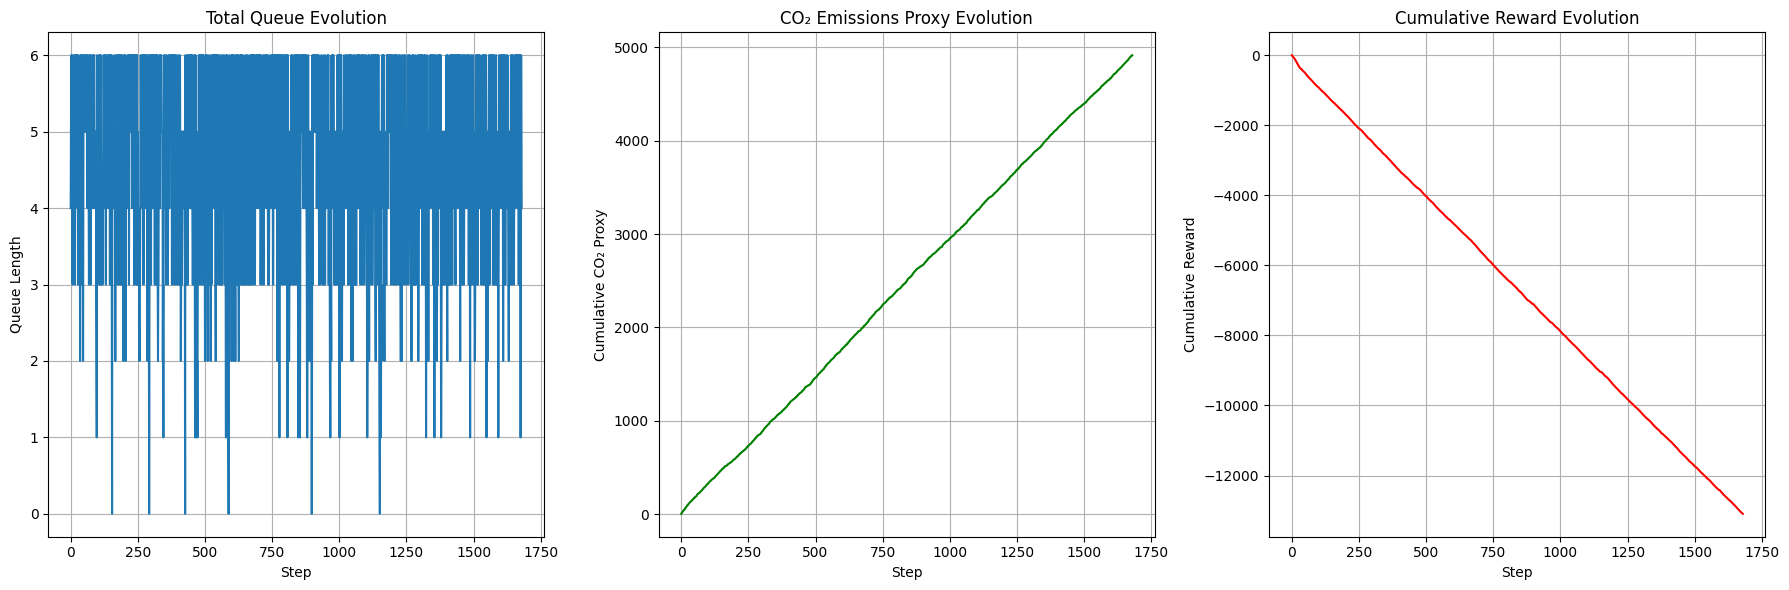

(weather
 clear    4.559196
 rain     4.626113
 Name: total_queue, dtype: float64,
 event_active
 False    4.564798
 True     5.190476
 Name: total_queue, dtype: float64)

In [6]:
import matplotlib.pyplot as plt

df_random = pd.read_csv('traffic_simulation_log.csv')

df_random['total_queue'] = df_random['queue_ns'] + df_random['queue_ew']

# CO2 proxy (idle time * duration / 60)
action_durations = {
    'GREEN_NS_30': 30,
    'GREEN_EW_30': 30,
    'GREEN_NS_60': 60,
    'GREEN_EW_60': 60,
    'ALL_RED_10': 10
}
df_random['action_duration'] = df_random['action'].map(action_durations)
df_random['co2_proxy'] = df_random['total_queue'] * df_random['action_duration'] / 60


plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(df_random['step'], df_random['total_queue'], label='Total Queue')
plt.xlabel('Step')
plt.ylabel('Queue Length')
plt.title('Total Queue Evolution')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(df_random['step'], df_random['co2_proxy'].cumsum(), label='Cumulative CO₂ Proxy', color='green')
plt.xlabel('Step')
plt.ylabel('Cumulative CO₂ Proxy')
plt.title('CO₂ Emissions Proxy Evolution')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(df_random['step'], df_random['reward'].cumsum(), label='Cumulative Reward', color='red')
plt.xlabel('Step')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward Evolution')
plt.grid(True)

plt.tight_layout()
plt.show()

# impact of weather
avg_queue_weather = df_random.groupby('weather')['total_queue'].mean()

# event activation
avg_queue_event = df_random.groupby('event_active')['total_queue'].mean()

(avg_queue_weather, avg_queue_event)

In [7]:
# Value iteration

def value_iteration(env, discount_factor=0.95, theta=0.001, max_iterations=1000):
    """
    Args:
        env: The MDP environment
        discount_factor: Gamma discount factor
        theta: Stopping threshold
        max_iterations: Maximum number of iterations

    Returns:
        V: Optimal state value function
        policy: Optimal action for each state
    """
    states = env.get_possible_states()
    V = {state.to_tuple(): 0.0 for state in states}  # Initialize V(s) = 0
    policy = {}

    for i in range(max_iterations):
        delta = 0
        for state in states:
            state_key = state.to_tuple()

            action_values = {}
            for action in TrafficAction:
                next_state = env.transition(state, action, step=0, current_hour=12)  # noon 
                reward = env.reward(state, action)
                next_state_key = next_state.to_tuple()

                action_value = reward + discount_factor * V.get(next_state_key, 0.0)
                action_values[action] = action_value

            # Best action value
            best_action = max(action_values, key=action_values.get)
            best_action_value = action_values[best_action]

            delta = max(delta, np.abs(best_action_value - V[state_key]))
            V[state_key] = best_action_value
            policy[state_key] = best_action

        if delta < theta:
            print(f"Value Iteration converged after {i+1} iterations.")
            break

    return V, policy

In [8]:
V_optimal, optimal_policy = value_iteration(env)

In [9]:
current_state = random.choice(env.get_possible_states())  # Random starting state
log_optimal = []

for step in range(total_steps):
    hour = step % 24
    day_index = (step // 24) % 7
    day_name = days[day_index]
    weekday_type = 'weekday' if day_name in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] else 'weekend'

    state_key = current_state.to_tuple()

    if state_key in optimal_policy:
        action = optimal_policy[state_key]
    else:
        action = random.choice(list(TrafficAction))  # fallback

    next_state = env.transition(current_state, action, step, hour)
    reward = env.reward(current_state, action)

    log_optimal.append({
        'step': step,
        'hour': hour,
        'day': day_name,
        'queue_ns': current_state.queue_ns,
        'queue_ew': current_state.queue_ew,
        'time_of_day': current_state.time_of_day,
        'day_of_week': current_state.day_of_week,
        'weather': current_state.weather,
        'event_active': current_state.event_active,
        'event_type': current_state.event_type,
        'nearby_landmark': current_state.nearby_landmark,
        'action': action.name,
        'reward': reward
    })

    current_state = next_state

df_log_optimal = pd.DataFrame(log_optimal)
df_log_optimal.to_csv('traffic_simulation_log_optimal.csv', index=False)

print("done")

done


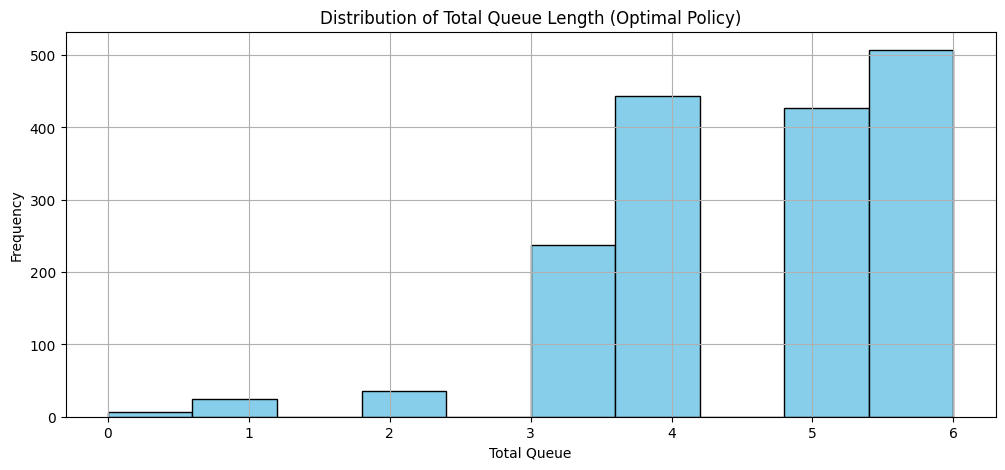

In [10]:
df_optimal = pd.read_csv('traffic_simulation_log_optimal.csv')

# Queue distribution
plt.figure(figsize=(12,5))
plt.hist(df_optimal['queue_ns'] + df_optimal['queue_ew'], bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of Total Queue Length (Optimal Policy)')
plt.xlabel('Total Queue')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [11]:
action_durations = {
    'GREEN_NS_30': 30,
    'GREEN_EW_30': 30,
    'GREEN_NS_60': 60,
    'GREEN_EW_60': 60,
    'ALL_RED_10': 10
}
df_optimal['action_duration'] = df_optimal['action'].map(action_durations)

# metrics
average_total_queue = df_optimal['queue_ns'].add(df_optimal['queue_ew']).mean()
total_co2_proxy = (df_optimal['queue_ns'] + df_optimal['queue_ew']) * df_optimal['action_duration'] / 60
total_co2 = total_co2_proxy.sum()
final_cumulative_reward = df_optimal['reward'].cumsum().iloc[-1]

# Weather impact
avg_queue_clear = df_optimal[df_optimal['weather'] == 'clear']['queue_ns'].add(
    df_optimal[df_optimal['weather'] == 'clear']['queue_ew']).mean()
avg_queue_rain = df_optimal[df_optimal['weather'] == 'rain']['queue_ns'].add(
    df_optimal[df_optimal['weather'] == 'rain']['queue_ew']).mean()

# Event impact
avg_queue_event = df_optimal[df_optimal['event_active'] == True]['queue_ns'].add(
    df_optimal[df_optimal['event_active'] == True]['queue_ew']).mean()
avg_queue_no_event = df_optimal[df_optimal['event_active'] == False]['queue_ns'].add(
    df_optimal[df_optimal['event_active'] == False]['queue_ew']).mean()


print("Optimal policy evaluation:")
print(f"Average Total Queue: {average_total_queue:.2f}")
print(f"Total CO₂ Proxy Emissions: {total_co2:.2f}")
print(f"Final Cumulative Reward: {final_cumulative_reward:.2f}")
print(f"Average Queue in Clear Weather: {avg_queue_clear:.2f}")
print(f"Average Queue in Rain: {avg_queue_rain:.2f}")
print(f"Average Queue with Event: {avg_queue_event:.2f}")
print(f"Average Queue without Event: {avg_queue_no_event:.2f}")

Optimal policy evaluation:
Average Total Queue: 4.62
Total CO₂ Proxy Emissions: 4751.50
Final Cumulative Reward: -13153.70
Average Queue in Clear Weather: 4.62
Average Queue in Rain: nan
Average Queue with Event: 4.91
Average Queue without Event: 4.61


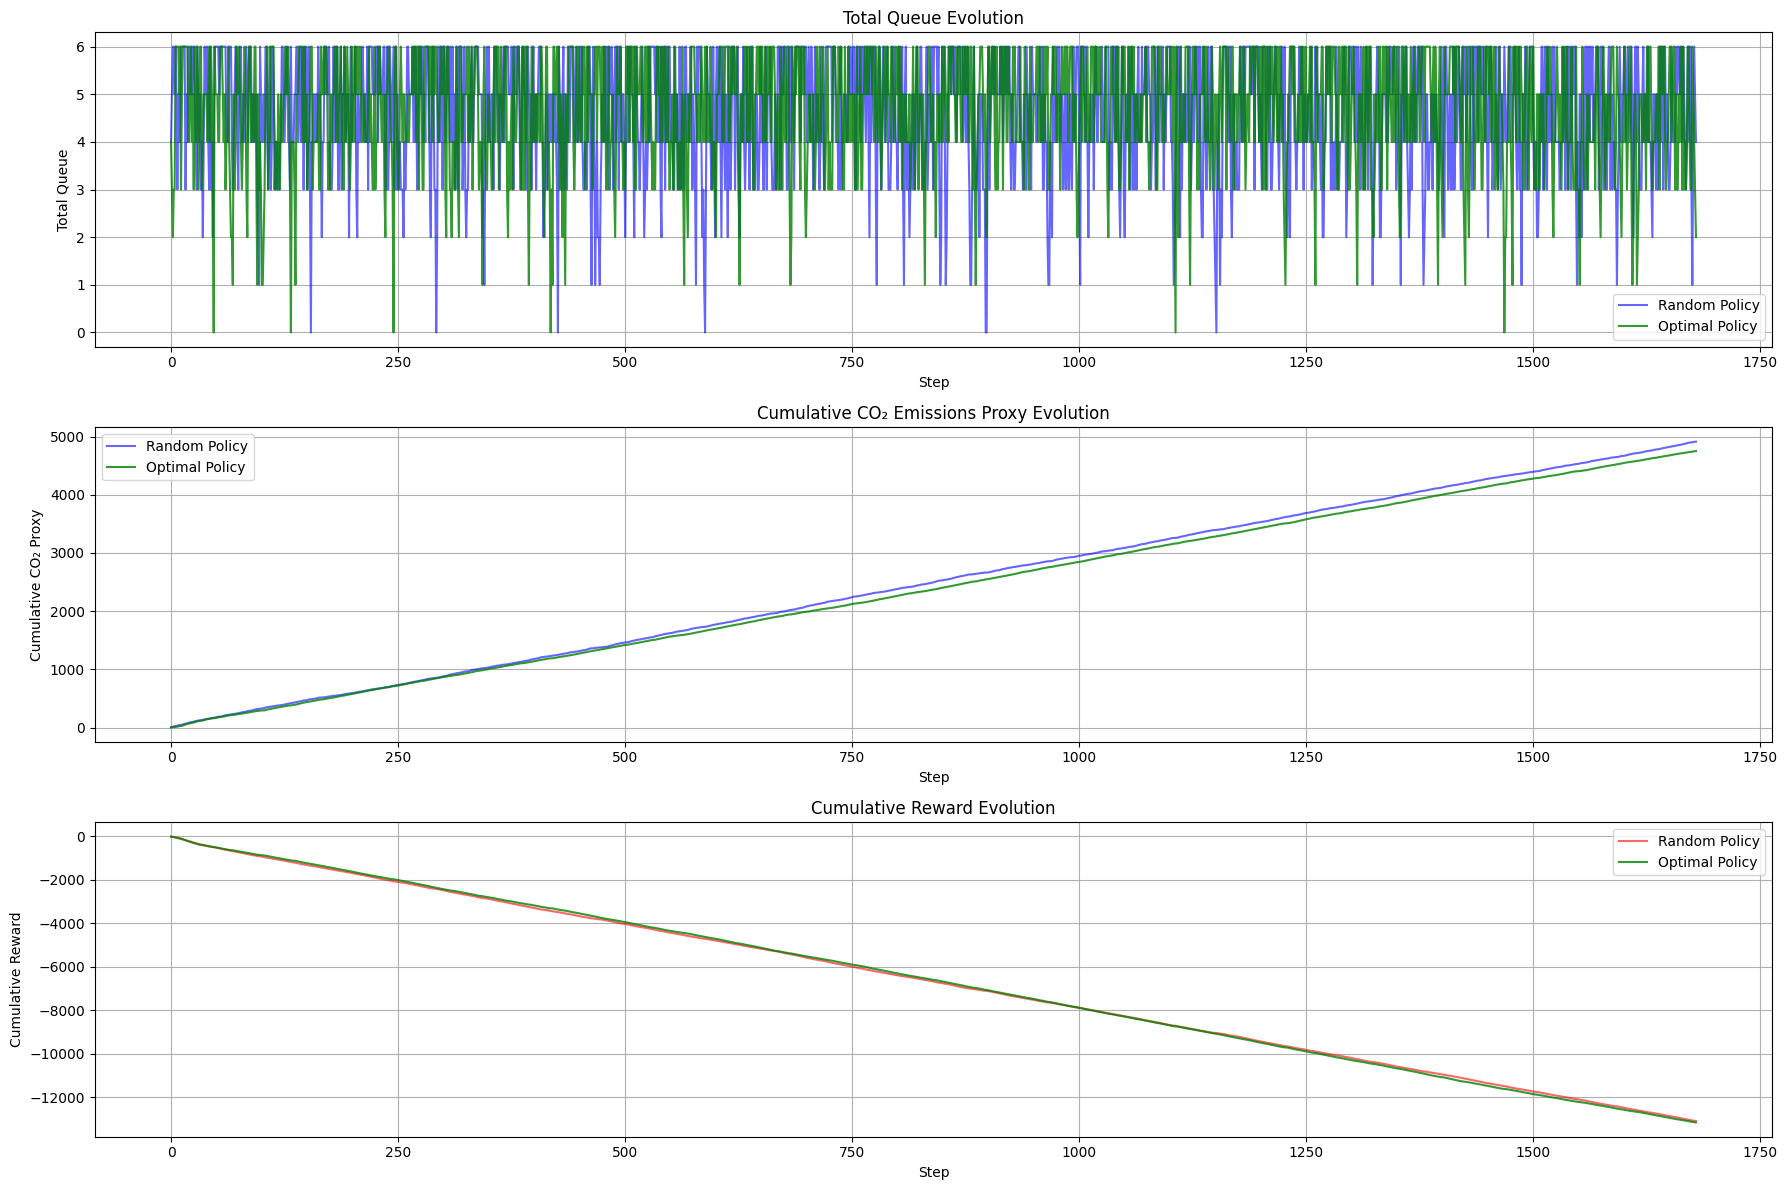

In [12]:
# Comparaison 

for df in [df_random, df_optimal]:
    df['total_queue'] = df['queue_ns'] + df['queue_ew']
    action_durations = {
        'GREEN_NS_30': 30,
        'GREEN_EW_30': 30,
        'GREEN_NS_60': 60,
        'GREEN_EW_60': 60,
        'ALL_RED_10': 10
    }
    df['action_duration'] = df['action'].map(action_durations)
    df['co2_proxy'] = df['total_queue'] * df['action_duration'] / 60



plt.figure(figsize=(18, 12))

# Total Queue 
plt.subplot(3, 1, 1)
plt.plot(df_random['step'], df_random['total_queue'], label='Random Policy', color='blue', alpha=0.6)
plt.plot(df_optimal['step'], df_optimal['total_queue'], label='Optimal Policy', color='green', alpha=0.8)
plt.title('Total Queue Evolution')
plt.xlabel('Step')
plt.ylabel('Total Queue')
plt.legend()
plt.grid(True)

# Cumulative CO₂ 
plt.subplot(3, 1, 2)
plt.plot(df_random['step'], df_random['co2_proxy'].cumsum(), label='Random Policy', color='blue', alpha=0.6)
plt.plot(df_optimal['step'], df_optimal['co2_proxy'].cumsum(), label='Optimal Policy', color='green', alpha=0.8)
plt.title('Cumulative CO₂ Emissions Proxy Evolution')
plt.xlabel('Step')
plt.ylabel('Cumulative CO₂ Proxy')
plt.legend()
plt.grid(True)

# Cumulative Rewards
plt.subplot(3, 1, 3)
plt.plot(df_random['step'], df_random['reward'].cumsum(), label='Random Policy', color='red', alpha=0.6)
plt.plot(df_optimal['step'], df_optimal['reward'].cumsum(), label='Optimal Policy', color='green', alpha=0.8)
plt.title('Cumulative Reward Evolution')
plt.xlabel('Step')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [13]:
# Average Total Queue
avg_queue_random = df_random['total_queue'].mean()
avg_queue_optimal = df_optimal['total_queue'].mean()

# Total CO₂ Proxy
total_co2_random = df_random['co2_proxy'].sum()
total_co2_optimal = df_optimal['co2_proxy'].sum()

# Final Cumulative Reward
final_reward_random = df_random['reward'].cumsum().iloc[-1]
final_reward_optimal = df_optimal['reward'].cumsum().iloc[-1]

print(f"Average Total Queue - Random: {avg_queue_random:.2f} vs Optimal: {avg_queue_optimal:.2f}")
print(f"Total CO₂ Proxy - Random: {total_co2_random:.2f} vs Optimal: {total_co2_optimal:.2f}")
print(f"Final Cumulative Reward - Random: {final_reward_random:.2f} vs Optimal: {final_reward_optimal:.2f}")

Average Total Queue - Random: 4.57 vs Optimal: 4.62
Total CO₂ Proxy - Random: 4914.17 vs Optimal: 4751.50
Final Cumulative Reward - Random: -13090.75 vs Optimal: -13153.70


In [14]:
def policy_iteration(env, discount_factor=0.95, max_iterations=100):
    """
    Run Policy Iteration to find the optimal policy.
    """
    states = env.get_possible_states()
    policy = {state.to_tuple(): np.random.choice(list(TrafficAction)) for state in states}
    V = {state.to_tuple(): 0.0 for state in states}

    for i in range(max_iterations):
        # Policy evaluation
        while True:
            delta = 0
            for state in states:
                s = state.to_tuple()
                action = policy[s]
                next_state = env.transition(state, action, step=0, current_hour=12)
                reward = env.reward(state, action)
                ns = next_state.to_tuple()
                new_v = reward + discount_factor * V.get(ns, 0)
                delta = max(delta, abs(new_v - V[s]))
                V[s] = new_v
            if delta < 1e-3:
                break

        # Policy improvement
        policy_stable = True
        for state in states:
            s = state.to_tuple()
            old_action = policy[s]
            action_values = {}

            for action in TrafficAction:
                next_state = env.transition(state, action, step=0, current_hour=12)
                reward = env.reward(state, action)
                ns = next_state.to_tuple()
                action_values[action] = reward + discount_factor * V.get(ns, 0)

            best_action = max(action_values, key=action_values.get)
            policy[s] = best_action

            if best_action != old_action:
                policy_stable = False

        if policy_stable:
            print(f"Policy iteration converged after {i + 1} iterations.")
            break

    return V, policy

In [15]:
def simulate_policy(env, policy, total_steps=1680):
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    log = []
    state = random.choice(env.get_possible_states())

    for step in range(total_steps):
        hour = step % 24
        day_name = days[(step // 24) % 7]
        s_key = state.to_tuple()

        action = policy.get(s_key, random.choice(list(TrafficAction)))
        next_state = env.transition(state, action, step, hour)
        reward = env.reward(state, action)

        log.append({
            "step": step,
            "hour": hour,
            "day": day_name,
            "queue_ns": state.queue_ns,
            "queue_ew": state.queue_ew,
            "reward": reward,
            "action": action.name,
            "event_active": state.event_active,
            "weather": state.weather
        })

        state = next_state

    return pd.DataFrame(log)

In [16]:
import matplotlib.pyplot as plt

def plot_policy_comparison(df_value, df_policy, label1="Value iteration", label2="Policy iteration"):
    plt.figure(figsize=(14, 5))

    # Reward
    plt.subplot(1, 3, 1)
    plt.plot(df_value['reward'].cumsum(), label=label1)
    plt.plot(df_policy['reward'].cumsum(), label=label2)
    plt.title("Cumulative reward")
    plt.xlabel("Steps")
    plt.ylabel("Cumulative reward")
    plt.legend()

    # Queue
    plt.subplot(1, 3, 2)
    q1 = df_value['queue_ns'] + df_value['queue_ew']
    q2 = df_policy['queue_ns'] + df_policy['queue_ew']
    plt.plot(q1.rolling(30).mean(), label=label1)
    plt.plot(q2.rolling(30).mean(), label=label2)
    plt.title("Total queue length (rolling avg)")
    plt.xlabel("Steps")
    plt.ylabel("Queue length")
    plt.legend()

    # CO2 Proxy
    def estimate_co2(df):
        duration_map = {
            'GREEN_NS_30': 30, 'GREEN_EW_30': 30,
            'GREEN_NS_60': 60, 'GREEN_EW_60': 60,
            'ALL_RED_10': 10
        }
        durations = df['action'].map(duration_map)
        total_queue = df['queue_ns'] + df['queue_ew']
        return (total_queue * durations / 60).cumsum()

    plt.subplot(1, 3, 3)
    plt.plot(estimate_co2(df_value), label=label1)
    plt.plot(estimate_co2(df_policy), label=label2)
    plt.title("Cumulative CO₂ Proxy")
    plt.xlabel("Steps")
    plt.ylabel("Idle time proxy")
    plt.legend()

    plt.tight_layout()
    plt.show()